In [1]:
%matplotlib

Using matplotlib backend: <object object at 0x10b98e350>


In [2]:
import mne
from pprint import pprint
import json
import csv
import numpy as np
import pandas as pd
from pathlib import Path
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)

In [37]:
root_data_path = Path("/Volumes/Neurolang_1/Project_Assistant/2021_Ongoing/2020_LTTC/Experiment_materials/LTTC_MEG")
meg_data_path = root_data_path / "LTTC_MEG_ALL_results"

print(root_data_path)

sub_id = 3

LDT_confile = meg_data_path / Path('de%.3d-2.con' %sub_id) 
LDT_raw =  mne.io.read_raw_kit(LDT_confile, stim = [195], preload=True) #, slope = '+') #slope=將3個stim_channel的訊號全部加成,讓訊號增強
                                                                #把原始的KIT資料讀進來
events = mne.find_events(LDT_raw, stim_channel='STI 014') #將集合而成的channel命名為STI 014

#LDT_raw.plot()
n_LDT_raw = LDT_raw.copy()

n_LDT_raw.load_data().pick_types(meg=True, stim=True).filter(0, 30, phase='zero-double').resample(500)
print(n_LDT_raw.info)
print(events.shape)

n_LDT_raw.plot()

/Volumes/Neurolang_1/Project_Assistant/2021_Ongoing/2020_LTTC/Experiment_materials/LTTC_MEG
Extracting SQD Parameters from /Volumes/Neurolang_1/Project_Assistant/2021_Ongoing/2020_LTTC/Experiment_materials/LTTC_MEG/LTTC_MEG_ALL_results/de003-2.con...
Creating Raw.info structure...
Setting channel info structure...
Creating Info structure...
Reading 0 ... 324999  =      0.000 ...   324.999 secs...
Ready.
Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
120 events found
Event IDs: [1]
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-

Closing raw-browser...
Channels marked as bad:
none


In [11]:
# get to know the reason of bad epoch drop
print(epoch_LDT.drop_log)

((), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('MEG 034',), (), ('MEG 033', 'MEG 034'), (), (), (), (), (), ('MEG 033', 'MEG 034'), (), (), (), (), (), (), (), (), ('MEG 034',), (), (), (), (), (), ('MEG 098',), (), (), (), (), (), (), (), (), (), ('MEG 034',), (), ('MEG 034', 'MEG 097', 'MEG 098', 'MEG 115', 'MEG 116'), (), (), (), (), (), (), (), (), ())


In [38]:
# ICA
ica_ = ICA(n_components=15, random_state=97)
ica_.fit(n_LDT_raw)
#ica_

#Plot ICA
ica_.plot_sources(n_LDT_raw)
ica_.plot_components()#sphere = (0.0, 0.02, 0.0, 0.065))  # What is this sphere for??
#ica_.plot_overlay(n_LDT_raw, exclude=[0, 5])

Fitting ICA to data using 157 channels (please be patient, this may take a while)


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_42094/2960612896.py:3: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica_.fit(n_LDT_raw)


Selecting by number: 15 components
Fitting ICA took 5.2s.
Creating RawArray with float64 data, n_channels=15, n_times=162500
    Range : 0 ... 162499 =      0.000 ...   324.998 secs
Ready.
Opening ica-browser...
Using pyopengl with version 3.1.6


[<MNEFigure size 1950x1463 with 15 Axes>]

Closing ica-browser...


In [35]:
# Checking for every component
for i in range(15):
    #ica_.plot_properties(n_raw, picks=[i])
    ica_.plot_overlay(n_LDT_raw, exclude=[i])

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 157 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 157 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 157 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 157 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 157 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 157 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing o

In [40]:
# ICAed epochs
# excluding wanted components
ica_.exclude = [0, 1, 2]

ica_.apply(n_LDT_raw) #changes the Raw object in-place, so let's make a copy first:
n_LDT_raw.plot()

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 3 ICA components
    Projecting back using 157 PCA components
Opening raw-browser...
Using pyopengl with version 3.1.6


Closing raw-browser...
Channels marked as bad:
none


In [41]:
# Creating the epochs(The Original one_without the tag of H&L-CD )
events = mne.find_events(n_LDT_raw, stim_channel='STI 014')  #just checking what stim_channel documenting what.
event_id = {'word_onset': 1}  

tmin = -0.1         								# pre stimulis interval (in seconds) #
tmax = 1       								# post stimulus interval #

baseline = (-0.1, 0)  # tmin ~ 0 , -0.1s-0s   
reject = dict(mag=4e-12)  # 5e-12 dropped so many

# Load in the channels layouts
kit_lay = mne.channels.read_layout("KIT-157")

#n_LDT_raw.load_data().pick_types(meg=True, stim=True).filter(0, 30, phase='zero-double').resample(500)
epoch_LDT = mne.Epochs(n_LDT_raw, events, event_id, tmin, tmax, baseline=baseline
                    , reject=reject,preload=True)

#epoch_LDT.plot()

Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
120 events found
Event IDs: [1]
Not setting metadata
120 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 120 events and 551 original time points ...
0 bad epochs dropped
Opening epochs-browser...
Using pyopengl with version 3.1.6


Waiting for Loading-Thread to finish... (max. 10 sec)
Closing epochs-browser...
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [59]:
# Load in the csv file of word onset
print(root_data_path)
csv_data = root_data_path / "001-015_PLDT_raw_results.csv"  # self-made LMM data form

sub_ansLIST = []
with open(csv_data, "r", encoding="UTF-8") as f:
    fileLIST = f.read().split("\n")
    fileLIST.pop(0)  # exclude the headlines
    fileLIST.pop(-1) # exclude the last one (blank)
    
    pprint(fileLIST[0:10][2])
    print(len(fileLIST))

/Volumes/Neurolang_1/Project_Assistant/2021_Ongoing/2020_LTTC/Experiment_materials/LTTC_MEG
'001,L,3,baepay,1,0,913.0,'
1800


In [67]:
# set up the sub_id into string
tmp_id = "%.3d" %sub_id
print(tmp_id)

# create blank LIST for later use
sub_ansLIST = []

# create the LIST of the target sub's answer
for row in fileLIST:
    row = row.split(",")
    sub_id_STR = row[0]
    
    # check the sub_id in the whole dataset
    if sub_id_STR == tmp_id:
        sub_ansLIST.append(row)
    else:
        pass
pprint(sub_ansLIST)
print(len(sub_ansLIST))

003
[['003', 'C', '1', 'weyaet', '1', '1', '1840.0', ''],
 ['003', 'C', '2', 'aegliy', '1', '1', '1315.0', ''],
 ['003', 'L', '3', 'paenliy', '1', '0', '1130.0', ''],
 ['003', 'L', '4', 'laelaxst', '1', '0', '2037.0', ''],
 ['003', 'C', '5', 'laeviy', '1', '1', '1098.0', ''],
 ['003', 'C', '6', 'baydiy', '1', '1', '1088.0', ''],
 ['003', 'H', '7', 'browmey', '1', '1', '1291.0', ''],
 ['003', 'H', '8', 'vaesow', '1', '1', '1109.0', ''],
 ['003', 'L', '9', 'baepay', '1', '1', '2063.0', ''],
 ['003', 'C', '10', 'chaeviy', '1', '1', '1277.0', ''],
 ['003', 'H', '11', 'payliy', '1', '0', '1090.0', ''],
 ['003', 'C', '12', 'maeskiy', '1', '1', '1197.0', ''],
 ['003', 'C', '13', 'weyaet', '2', '1', '1620.0', ''],
 ['003', 'L', '14', 'laelaxst', '2', '0', '2699.0', ''],
 ['003', 'H', '15', 'browmey', '2', '1', '968.0', ''],
 ['003', 'L', '16', 'paenliy', '2', '1', '2092.0', ''],
 ['003', 'C', '17', 'chaeviy', '2', '1', '2738.0', ''],
 ['003', 'H', '18', 'payliy', '2', '0', '1145.0', ''],
 ['00

In [68]:
all_eventsArray = events.copy()
#print(all_eventsArray[0][0])

# C == control group; H == H_CD; L == L_CD
# event_id >> C==9; H==1; L==2

C_LIST = []
H_LIST = []
L_LIST = []

# Change the event id according to the condition
for row in sub_ansLIST:
    print(row)
    
    index_eventINT = sub_ansLIST.index(row)
    #print(index_eventINT)
    conditionSTR = row[1]
    #print(row[0], row[1])
    
    if conditionSTR == "C":
        #print(index_eventINT, "=", conditionSTR)
        all_eventsArray[index_eventINT][2] = 9
        #C_LIST.append(conditionSTR)

    if conditionSTR == "H":
        #print(index_eventINT, "=", conditionSTR)
        all_eventsArray[index_eventINT][2] = 1
        #H_LIST.append(conditionSTR)
        
    if conditionSTR == "L":       
        #print(index_eventINT, "=", conditionSTR)
        all_eventsArray[index_eventINT][2] = 2
        #L_LIST.append(conditionSTR)
        else:
            pass 

all_eventsArray

SyntaxError: invalid syntax (1120550162.py, line 34)

In [23]:
# Creating the new epochs
events = all_eventsArray  #mne.find_events(raw_ICAed, stim_channel='STI 014')  #just checking what stim_channel documenting what.
event_id = {'High_CD':1,'Low_CD':2, 'Control': 9}  

tmin = -0.1         								# pre stimulis interval (in seconds) #
tmax = 0.7          								# post stimulus interval #

baseline = (None, 0)  # tmin ~ 0 , -0.1s-0s   
reject = dict(mag=4e-12)

# Load in the channels layouts
kit_lay = mne.channels.read_layout("KIT-157")

n_LDT_raw.load_data().pick_types(meg=True, stim=False).filter(0, 30, phase= 'zero-double').resample(500)
n_epoch_LDT = mne.Epochs(ICAed_LDT_raw, events, event_id, tmin, tmax,
                    baseline=baseline,
                    reject = reject, preload = True)

n_epoch_LDT

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 33.75 Hz)
- Filter length: 221 samples (0.442 sec)

Not setting metadata
Not setting metadata
120 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 120 events and 401 original time points ...
0 bad epochs dropped


<Epochs |  120 events (all good), -0.1 - 0.7 sec, baseline [-0.1, 0] sec, ~58.2 MB, data loaded,
 'Control': 60
 'High_CD': 30
 'Low_CD': 30>

In [29]:
n_epoch_LDT.save(meg_data_path / 'S001_ICAed_LDT-epo.fif', overwrite=True)

Overwriting existing file.


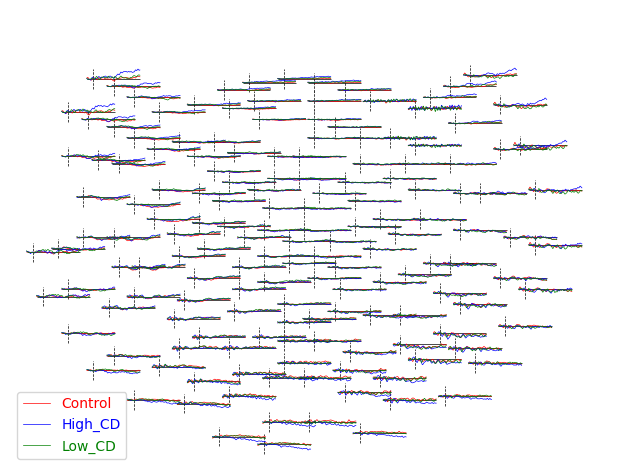

In [25]:
evoked_C = n_epoch_LDT["Control"].average()
evoked_H = n_epoch_LDT["High_CD"].average()
evoked_L = n_epoch_LDT["Low_CD"].average()

evoked_C.comment = 'Control'
evoked_H.comment = 'High_CD'
evoked_L.comment = 'Low_CD'

tmp = [evoked_C, evoked_H, evoked_L] #[evoked_H, evoked_L]
colors = 'red', 'blue', 'green' #'blue', 'green'
mne.viz.plot_evoked_topo(tmp, color = colors)

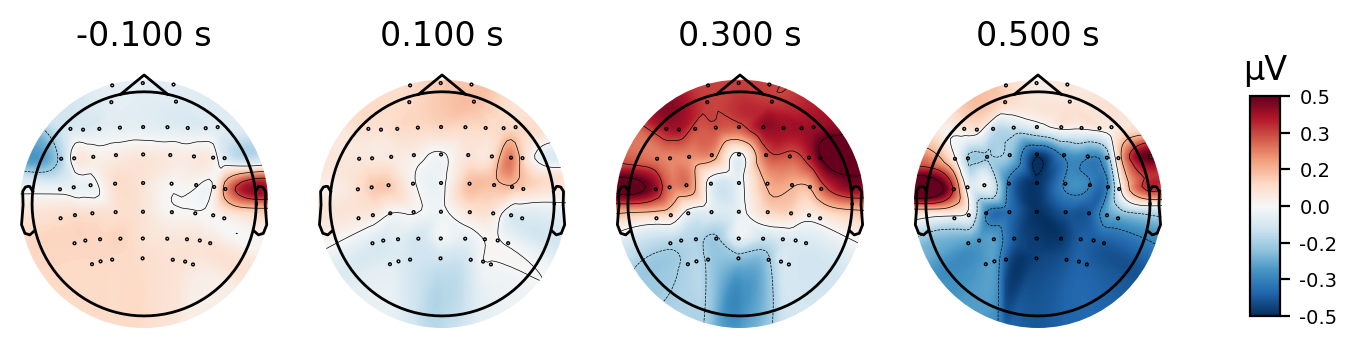

In [148]:
tape_evoked.plot_topomap()

In [ ]:
# see the average of the epochs, I think

std_evoked = epochs['Standard (yi3)'].average().apply_baseline((-0.1, 0)).pick_types(eeg= True, stim = False).crop(-0.1, 0.7)
devL_evoked = epochs['Large deviant (yi1)'].average().apply_baseline((-0.1, 0)).pick_types(eeg= True, stim = False).crop(-0.1, 0.7)
devS_evoked = epochs['Small deviant (yi2)'].average().apply_baseline((-0.1, 0)).pick_types(eeg= True, stim = False).crop(-0.1, 0.7)

print(std_evoked)
print(devL_evoked)
print(devS_evoked)

In [ ]:
tmp = [std_evoked, devL_evoked, devS_evoked]
colors = 'red', 'blue', 'green'
#mne.viz.plot_evoked_topo(tmp, color = colors, title = 'MMN', ylim = dict(eeg=[10, -10]))
mne.viz.plot_compare_evokeds(tmp, colors = colors, axes = 'topo')